In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import exp, expm1, log

from os import listdir
import glob

from mod_packs import quantum_potential as qp

C:\Users\Spock\Anaconda3\Anaconda33\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Importing Data 

In [2]:
Data = pd.read_csv('topten.csv').set_index('Date')
portfos = pd.read_csv('topten_portfos').set_index('Unnamed: 0')

In [3]:
for i in range(len(Data.columns)):
    ret1 = qp.scaled_return(Data[Data.columns[i]].values,1)
    Data[Data.columns[i]] = np.append(ret1,ret1[-1])

In [4]:
li = []

for filename in listdir():
    if filename[-3:]=='csv' and filename[:4]!='topt':
        df = pd.read_csv(filename)
        df.columns
        df = df.rename(columns={'Volume':filename.replace('.csv','_vol')})
        li.append(df)

In [5]:
dff = []
for i in range(len(li)):
    wer = np.char.endswith(list(li[i].columns),'vol')
    nam  = li[i].columns[wer][0]
    df1 = pd.DataFrame(li[i].set_index('Date')[nam])
    dff.append(df1)

# Cleaning Data 

In [6]:
dffs = dff[0]
for i in range(len(dff)-1):
    dffs = dffs.join(dff[i+1])

In [7]:
fdf = Data.join(dffs)

In [8]:
fdf = fdf.sort_index(axis=1)

In [9]:
portfos = portfos.sort_index(axis=0)

In [10]:
ine = portfos[portfos.columns[0]].values
ine = np.repeat(ine,2)

In [11]:
fdf_new = fdf*ine

In [12]:
sums = fdf_new.sum()[np.arange(10)*2+1]
ones = np.ones(10)
vol_sum = []
for i in range(len(sums)):
    vol_sum.append(ones[i])
    vol_sum.append(sums[i])

In [13]:
fdf_normalized = fdf_new.div(vol_sum)
portfolio_vol = fdf_normalized[dffs.columns].sum(axis=1)

# Dividing data into High and Low volume groups

In [14]:
port_vol = [portfolio_vol>np.mean(fdf_normalized[dffs.columns].sum(axis=1).values)][0]

In [15]:
price_df_high_vol = fdf_new[Data.columns][port_vol].sort_index(axis=1)
price_df_low_vol = fdf_new[Data.columns][np.invert(port_vol)].sort_index(axis=1)

In [16]:
high_vol_portfolio_return = qp.ind_generator(price_df_high_vol.values.T , portfos.values.T[0])
low_vol_portfolio_return = qp.ind_generator(price_df_low_vol.values.T , portfos.values.T[0])

# Calculating the risk for the two above groups

In [20]:
hlow , hup = qp.risk_data_input(high_vol_portfolio_return, 0.001)
hhrisk = hup - hlow

In [21]:
llow , lup = qp.risk_data_input(low_vol_portfolio_return, 0.001)
llrisk = lup - llow

([<matplotlib.axis.XTick at 0x1902cad9250>,
 [Text(1.8, 0, 'Low Volume'), Text(3.0, 0, ''), Text(4.2, 0, 'High Volume')])

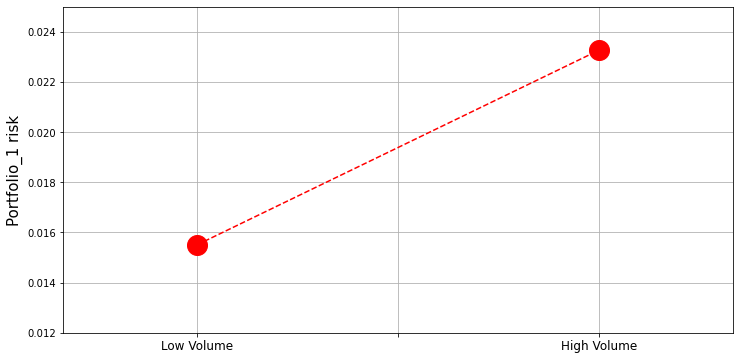

In [57]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1)

plt.plot([1.8,4.2], [llrisk , hhrisk] , 'ro--' , markersize=20)

plt.ylabel('Portfolio_1 risk' , fontsize=15)
plt.grid()
plt.xlim([1,5])
plt.ylim([0.012,0.025])
plt.xticks([1.8,3,4.2],['Low Volume','', 'High Volume'] , fontsize=12)

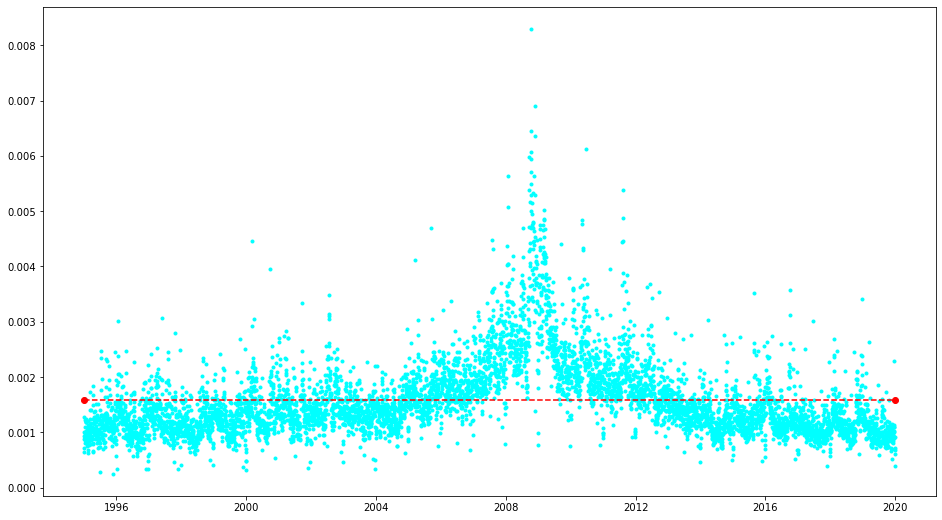

In [19]:
fig = plt.figure(figsize=(16,9))
plt.plot( pd.to_datetime(fdf_normalized.index),fdf_normalized[dffs.columns].sum(axis=1).values,'.', color='cyan')
plt.plot([pd.to_datetime(fdf_normalized.index)[0], pd.to_datetime(fdf_normalized.index)[-1]]\
         ,[np.mean(fdf_normalized[dffs.columns].sum(axis=1).values),\
         np.mean(fdf_normalized[dffs.columns].sum(axis=1).values)],'ro--')